In [3]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from scipy.optimize import root
from scipy.stats import linregress
%matplotlib inline
import matplotlib.pyplot as plt
import sys


# this is equialent of C++ bind 
#
def partial(func, *args, **kwargs):
    def f(*args_rest, **kwargs_rest):
        kw = kwargs.copy()
        kw.update(kwargs_rest)
        return func(*(args + args_rest), **kw) 
    return f


# we use this to convert discrete domains into
# continous functions using the partial defined above
# tt is the time domain array of the function 
# vv is the corresponding range array of the function 
# t  is the point were we are interpolating 
#
def interpolator(tt,vv,t):
    return np.interp(t,tt,vv)


# takes a func(t) defined over a domain period 
# and makes it periodic with regards to t
#
def make_periodic(func,period,t):
    return func(t-(t//period)*period)


class TransistorModel:
    
    # 
    # public interface 
    #

    # constructor
    #
    def __init__(self, Cion, Rion):
        
        self.Cion=7.2e-6
        self.Rion=6.7e4
        
    # single transistor model
    # the tt defines the domain on which 
    # to evaluate the vfunc
    #
    def apply_1T_model(self,Qstart,tt,vfunc):

        v_array=np.array([vfunc(t) for t in tt])
        q_swipe=self.evolve_charge(Qstart,tt,vfunc)

        return (self.j1_1t(q_swipe/self.Cion,v_array),v_array,q_swipe)     
    
    
    #
    # private
    #


    # defines a differential equation for the 
    # evolution of change vs applied voltage over time 
    #
    # returns a difference term for a point in time
    def memdiode(self,q,t,vfunc):
        R = self.Rion
        C = self.Cion

        dqdt = (vfunc(t) - 2*q/C)/R

        return dqdt
    
    
    def evolve_charge(self,Qstart,tt,vfunc):

        # solve and reshape the result to an array from a 1D vector
        q=odeint(self.memdiode,Qstart,tt,args=(vfunc,))
        q=q.reshape(len(tt))

        return q    
    

    # C=Q/V
    #
    # V=Q/C
    #
    # V kg·m2·s−3·A−1   (or J/C)
    #
    # single transistor model 
    #
    def j1_1t(self,Vc,V):

        v1=V-Vc
        
        j = self.js1 * ( np.exp((self.e*v1)/(self.m1*self.kb*self.T),dtype=np.float64) - \
                         np.exp((self.e*(v1-V))/(self.m1*self.kb*self.T),dtype=np.float64) ) - \
                         self.jphoto

        return j  


    ###################################################################
    # constants 

    e   = 1.60217662e-19 # A * s
    kb  = 1.38064852e-23 # J/K
        
    # physical parameters
        
    mss=1.93
    fc=0.7
    m1=mss*(1-fc/2)

    js1 = 6.1e-10        # A/m  -10
    js2 = 6.1e-7        # A/m    used to be -7  , -3 gave us the flat Vn on 0
    jphoto=0.          # our generation photo current
    T=300


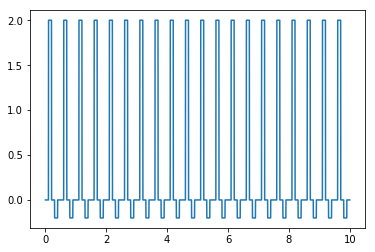

In [38]:
def voltage_lin_sweep(Vi,s,t):
    return (Vi + s*t)

def voltage_bidirectional_sweep(Vi,s,switch_time,t):
    if(t>=switch_time):
        ret = (Vi + s*switch_time) - s*(t-switch_time)
    else:
        ret = (Vi + s*t)
    return ret

# this function, when used in the context of odeint 
# is not a vector function, t is simply a scalar
#
def voltage_pulse(Vmin,Vmax,fr,to,t):
    if( t >= fr and t<to ):
        return Vmax
    else:
        return Vmin
    
# these are our discrete ranges 
# we need to specify both range and value axes 

pulse_t=[0,0.2,0.20001,0.3,0.30001,0.5]
pulse_v=[0,0,2,2,0,0]

double_pulse_t=[0,0.1,0.10001,0.2,0.20001,0.3,0.30001,0.4,0.40001,0.5]
double_pulse_v=[0,0,2,2,0,0,2,2,0,0]
    
double_pulse_pos_neg_v=[0,0,2,2,0,0,-.2,-.2,0,0]

# here we have the self adjusting definitions for sweeps 
# we can vary number of timeseps (resolution)
# the range 
# and the vale range 

timesteps=10000
time=.5
v_range=.5 # full range (from - to +, e.g. -1 -> 1 : range is 2)
time_domain=np.linspace(0,time,timesteps,dtype=np.float64)
scan_rate=2*v_range/time

# here we have the voltage profiles specified as analytical functions 

vls    = partial(voltage_lin_sweep,-v_range/2.,scan_rate)
vlsbd  = partial(voltage_bidirectional_sweep,-v_range/2.,scan_rate,time/2.)
vpulse = partial(voltage_pulse,0,2,0.2,0.3)

# here we have the ranges specified as discrete timeseries
# with the interpolated intermediate points 

vpulse_discrete=partial(interpolator,pulse_t,pulse_v)   
vpulse_double_discrete=partial(interpolator,double_pulse_t,double_pulse_v)    
vpulse_double_pos_neg_discrete=partial(interpolator,double_pulse_t,double_pulse_pos_neg_v)    


# here we select the v(t) function to be used in our calculations 

#vf=vlsbd
vf=partial(make_periodic,vpulse_double_pos_neg_discrete,0.5)
time_domain_periodic=np.linspace(0,10,timesteps,dtype=np.float64)

time_domain=time_domain_periodic

v_array=np.array([vf(t) for t in time_domain])

plt.plot(time_domain,v_array)

tm = TransistorModel(Cion=1,Rion=2)

(i,v,q)=tm.apply_1T_model(0,time_domain,vf)

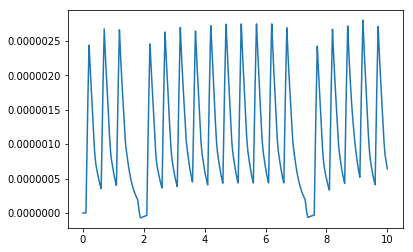

In [39]:
plt.plot(time_domain,q)

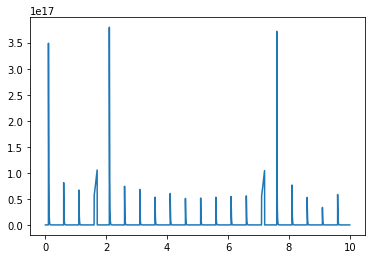

In [40]:
plt.plot(time_domain,i)

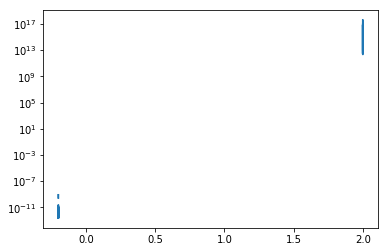

In [41]:
plt.semilogy(v,abs(i))
#plt.plot(v,i)

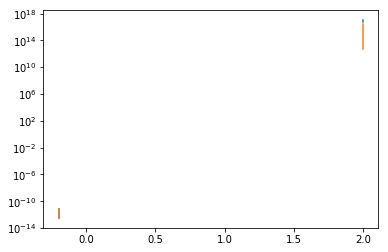

In [35]:
vup=v[0:499]
iup=i[0:499]

plt.semilogy(vup[230:270],abs(iup[230:270]))

vdn=v[500:999]
idn=i[500:999]

plt.semilogy(vdn[230:270],abs(idn[230:270]))